In [11]:
# Import all modules

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pprint
%matplotlib inline

### Camera Calibration

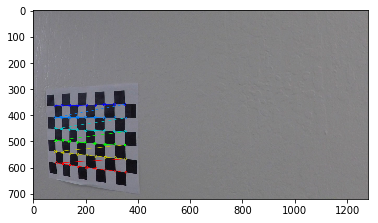

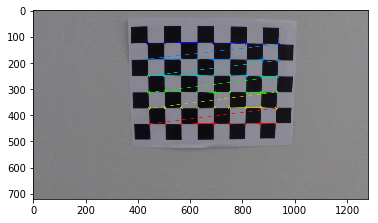

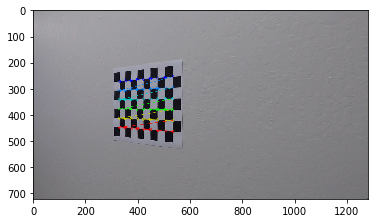

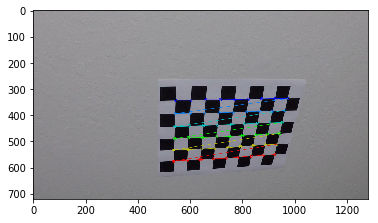

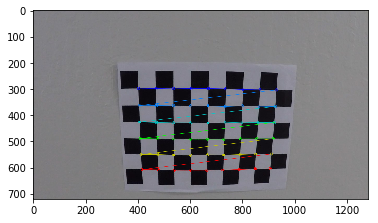

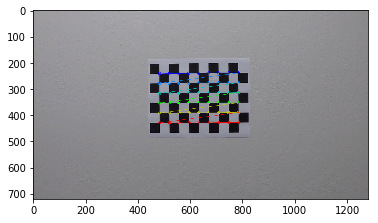

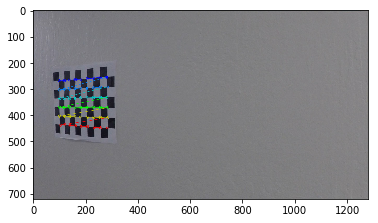

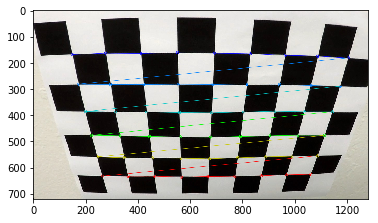

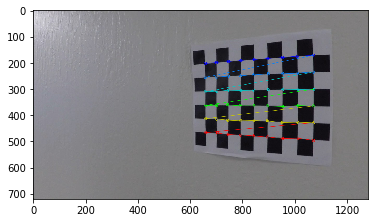

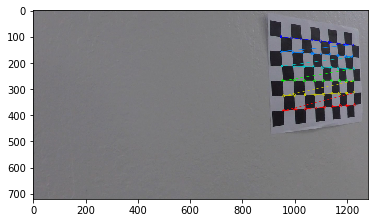

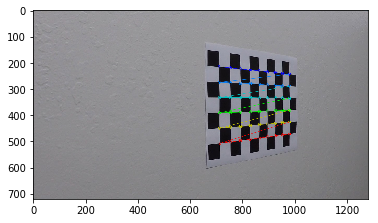

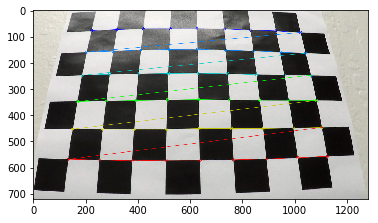

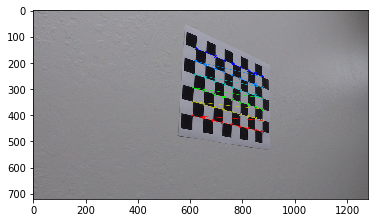

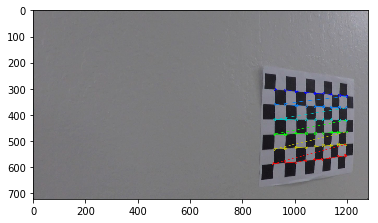

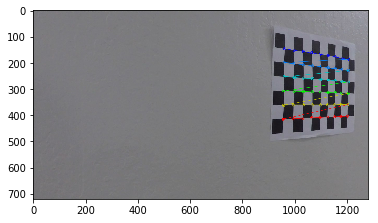

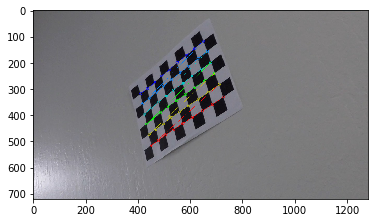

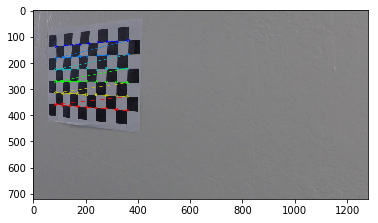

In [14]:
# Camera calibration

# Reading all calibration images' path
fnames = glob.glob('./camera_cal/calibration*.jpg')

# objpoints and imgpoints are corresponding points in object space and image space that we need to find the distortion coefficients
objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane

# Generating objpoints and imgpoints for each calibration image 
for fname in fnames:
    # prepare object points for each calibration image
    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # x, y coordinates
    # read image
    img = mpimg.imread(fname)
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    # if corners are found, add object points, image points to the arrays
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # drawing to display the corners
        img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        plt.imshow(img)
        plt.show()

In [16]:
# Reading in a test image to get its shape
test_img = mpimg.imread('./test_images/test1.jpg')
test_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

# Getting distortion coefficients from objpoints and imgpoints
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, test_gray.shape[::-1], None, None)

# Defining a function that removes camera distortion
def undistort(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

### Thresholding


In [76]:
# Reading and storing all test images after undistortion in a list for testing
fnames = glob.glob('./test_images/test*.jpg')

originals = []

for fname in fnames:
    img = mpimg.imread(fname)
    undist = undistort(img)
    originals.append(undist)
    
# Setting up a function to plot test images from a list like above
def plot_images(image_list):
    rows = 2
    cols = 3
    f,ax = plt.subplots(rows,cols,figsize=(20,int(13*rows/cols)))
    for i in range(len(image_list)):
        image = image_list[i]
        ax[int(i/cols),i%cols].imshow(image, cmap = 'gray')
    

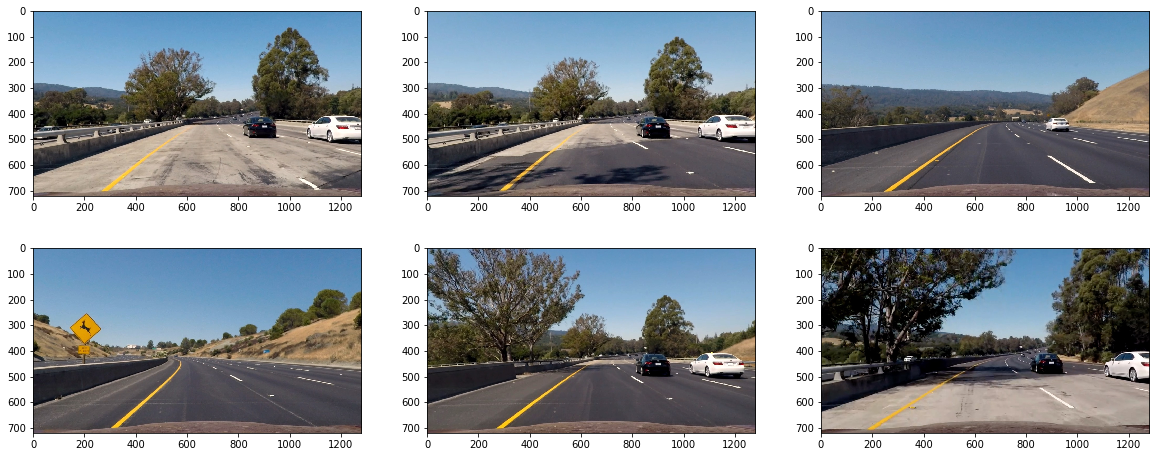

In [77]:
# Original undistorted test images
plot_images(originals)

L channel


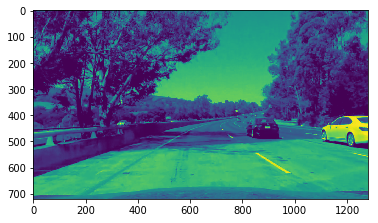

S channel


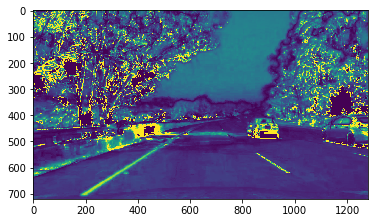

G channel


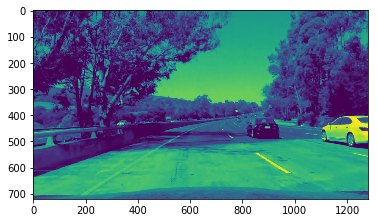

In [36]:
# Choosing test image
test_img = originals[5]

# Exploring color spaces and color channel on our test image
hls = cv2.cvtColor(test_img, cv2.COLOR_RGB2HLS)

# lightness channel from HLS space can be used to identify shadows
l_channel = hls[:,:,1]
print('L channel')
plt.imshow(l_channel)
plt.show()

# saturation channel from HLS space can be used to identify yellow lane pixels
s_channel = hls[:,:,2]
print('S channel')
plt.imshow(s_channel)
plt.show()

# g channel from RGB space can be used to pick up white lane pixels
g_channel = test_img[:,:,1]
print('G channel')
plt.imshow(g_channel)
plt.show()


In [65]:
# Defining helper function for thresholding

# thresh_inside() removes pixels within the threshold range
def thresh_inside(channel_image, channel_threshold):
    # getting range from channel_threshold
    thresh_min = channel_threshold[0]
    thresh_max = channel_threshold[1]
    binary = np.zeros_like(channel_image)
    binary[(channel_image >= thresh_min) & (channel_image <= thresh_max)] = 1
    return binary

# thresh_outside() retains pixels within th threshold range 
def thresh_outside(channel_image, channel_threshold):
    # getting range from channel_threshold
    thresh_min = channel_threshold[0]
    thresh_max = channel_threshold[1]
    binary = np.zeros_like(channel_image)
    binary[(channel_image <= thresh_min) | (channel_image >= thresh_max)] = 1
    return binary

In [66]:
# Defining functions that removes pixels using threshold values from thresholds dictionary

def apply_thresholds(image, thresholds):
    # Convert to HLS color space and separate the S and L channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    
    # G channel from image that is in RGB space
    g_channel = image[:,:,1]
    
    # Threshold s channel from the external thresholds dictionary
    s_threshold = thresholds['s_channel']
    s_binary = thresh_inside(s_channel, s_threshold)
    
    # Threshold l channel from the external thresholds dictionary
    l_threshold = thresholds['l_channel']
    l_binary = thresh_outside(l_channel, l_threshold)
    
    # Threshold g channel from the external thresholds dictionary
    g_threshold = thresholds['g_channel']
    g_binary = thresh_inside(g_channel, g_threshold)

    # Combine the three binary thresholds such that we retain only yellow and white lane pixels while rejecting shadow pixels
    combined_binary = np.zeros_like(s_binary)
    combined_binary[((s_binary == 1) | (g_binary == 1)) & (l_binary == 0)] = 1
    
    # Return the combined binary image
    return combined_binary

In [136]:
# Defining the thresholds for varios color channels in the thresholds dictionary
thresholds = {
    's_channel': [150, 255],
    'l_channel': [25, 255],
    'g_channel': [208, 255]
}

# and testing on the originals
thresholded_images = []

for image in originals:
    thresholded = apply_thresholds(image, thresholds)
    thresholded_images.append(thresholded)


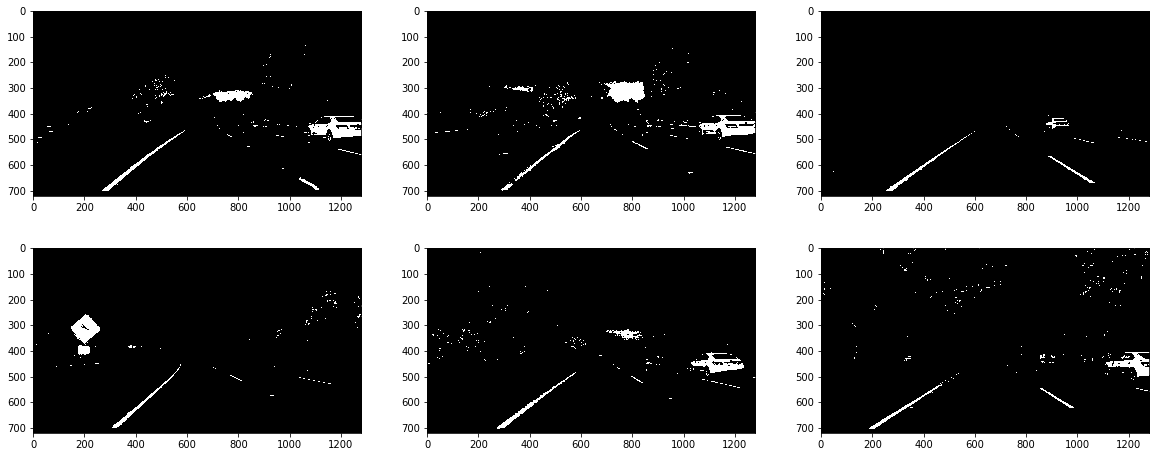

In [137]:
plot_images(thresholded_images)

### Perspective transform

In [97]:
# Defining of the source and destination points is done manually by looking at the straight lane line images
w,h = 1280,720
x,y = 0.5*w, 0.8*h
src = np.float32([[200./1280*w,720./720*h],
                  [453./1280*w,547./720*h],
                  [835./1280*w,547./720*h],
                  [1100./1280*w,720./720*h]])
dst = np.float32([[(w-x)/2.,h],
                  [(w-x)/2.,0.82*h],
                  [(w+x)/2.,0.82*h],
                  [(w+x)/2.,h]])

# M defines the transformation matrix from first person view as we have to bird's eye view of the road 
M = cv2.getPerspectiveTransform(src, dst)

# Minv is the reverse transformation matrix
Minv = cv2.getPerspectiveTransform(dst, src)

# warp() is a function that uses M to get the bird's eye view of the road
def warp(image):
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [143]:
# Testing warp() on our test images that have been thresholded

warped_images = []

for image in thresholded_images:
    warped = warp(image)
    warped_images.append(warped)

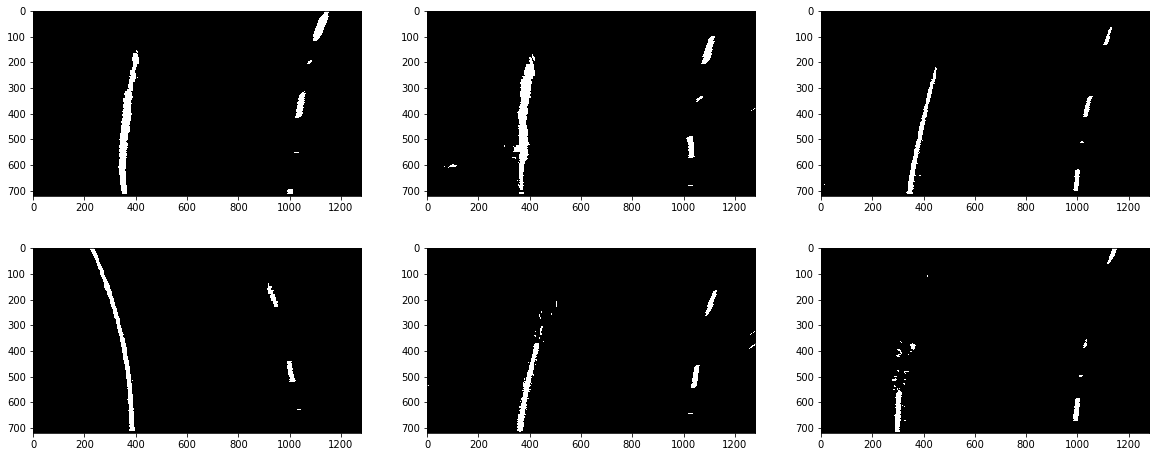

In [144]:
plot_images(warped_images)

#### Finding lines

In [172]:
# find_lines_initial() finds lines in an image which doesn't supersede any other image

def find_lines_initial(image):
    binary_warped = image
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)

#     plt.show()
    return left_fit, right_fit, left_fitx, right_fitx

In [173]:
out = []

for i in warped_images:
    left_fit, right_fit, left_fitx, right_fitx = find_lines_initial(i)
    out.append([left_fit, right_fit, left_fitx, right_fitx])

In [174]:
# find_lines_continuus() finds lines in an image where we have line info from the previous image farme

def find_lines_continuous(image, left_fit, right_fit):
    binary_warped = image
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # VISUALIZATION ################################################
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
#     plt.imshow(result)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
    
#     plt.show()
    return left_fit, right_fit, left_fitx, right_fitx

In [175]:
out_continuous = []

for i in range(len(warped_images)):
    [left_fit, right_fit] = out[i][:2]
    image = warped_images[i]
    left_fit_new, right_fit_new, left_fitx, right_fitx = find_lines_continuous(image, left_fit, right_fit)
    out_continuous.append([left_fit_new, right_fit_new, left_fitx, right_fitx])

### Measuring curvature and offset

In [157]:
def measure_curvature(image, left_fitx, right_fitx):
    binary_warped = image
    y_eval = binary_warped.shape[0]
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our mean radius of curvature is in meters
    mean_curverad = (left_curverad + right_curverad) / 2
    return(mean_curverad)

In [159]:
# Measuring and storing radius of curvature for test images
curvature_measurements = []

for i in range(len(warped_images)):
    [left_fitx, right_fitx] = out[i][2:4]
    image = warped_images[i]
    measurement = measure_curvature(image, left_fitx, right_fitx)
    curvature_measurements.append(measurement)
    
pprint.pprint(curvature_measurements)

[677.83184733723715,
 666.36883872985413,
 965.38863083182378,
 731.75198557180579,
 616.94370856467822,
 567.44770657699792]


In [167]:
# Measuring offset from the center of the lane
def measure_offset_at_base(image, left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y = image.shape[0]
    x_left_lane = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    x_right_lane = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
    lane_center = x_left_lane + ((x_right_lane - x_left_lane) / 2)
    car_center = image.shape[1] / 2
    # offset in pixels
    offset = lane_center - car_center
    # offset in meters
    offset_m = offset*xm_per_pix
    return offset_m

In [169]:
# Measuring and storing center offset for test images
center_offsets = []

for i in range(len(warped_images)):
    [left_fit, right_fit] = out[i][0:2]
    image = warped_images[i]
    measurement = measure_offset_at_base(image, left_fit, right_fit)
    center_offsets.append(measurement)
    
pprint.pprint(center_offsets)

[0.19461052988986038,
 0.29830135298040944,
 0.13874324157473242,
 0.37581188808397314,
 0.28368293027483482,
 0.016766172623121391]


In [183]:
# Final output image
def get_final_output(warped, undist, left_fitx, right_fitx):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
#     plt.imshow(result)
#     plt.show()
    return result

In [184]:
# testing the get_final_output() function on test images
final_images = []

for i in range(len(warped_images)):
    [left_fitx, right_fitx] = out[i][2:4]
    warped = warped_images[i]
    undist = originals[i]
    final_image = get_final_output(warped, undist, left_fitx, right_fitx)
    final_images.append(final_image)

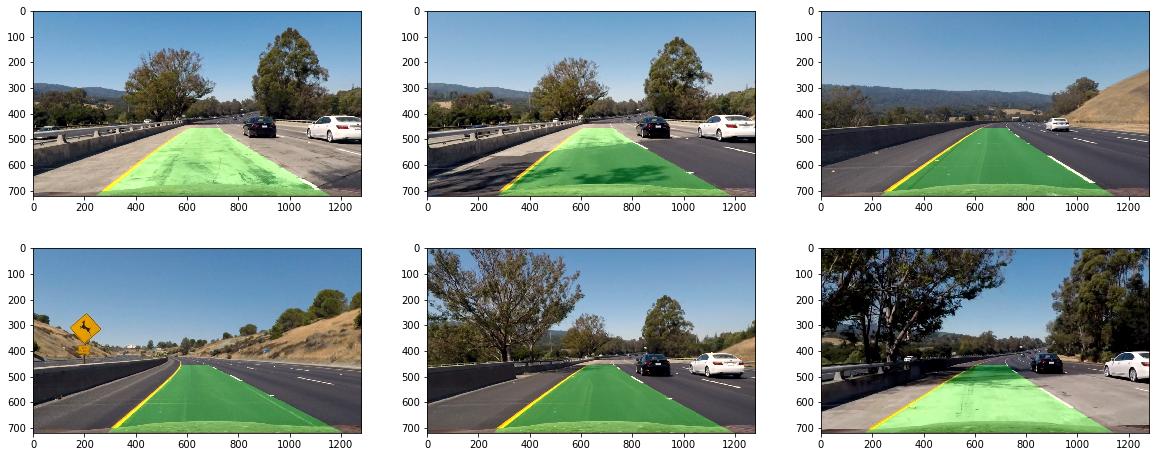

In [185]:
plot_images(final_images)